# Package

In [1]:
import numpy as np
import matplotlib.pyplot as plt

import torch
from torchvision import datasets, transforms

from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score
from scipy.spatial.distance import cdist
from scipy.stats import mode


from numpy.linalg import pinv




# Device

In [2]:
device = 'mps' if torch.backends.mps.is_available() else 'cpu'
print(device)

mps


# MNIST Data Loading

In [3]:
mnist_data = datasets.MNIST(root='./data', train=True, download=True)

print(mnist_data.data.min(), mnist_data.data.max())

all_image = mnist_data.data.numpy()     # (60000, 28, 28)
all_label = mnist_data.targets.numpy()  # (60000,)

print(all_image.min(), all_image.max())
print(all_image.shape, all_label.shape)



tensor(0, dtype=torch.uint8) tensor(255, dtype=torch.uint8)
0 255
(60000, 28, 28) (60000,)


# Preprocessing: Normalization

In [4]:
# Normalize to [0,1]
min, max = all_image.min(), all_image.max()
print(min, max)

if max > min:
    all_image_prepro = (all_image - min) / (max - min)
else:
    all_image_prepro = np.zeros_like(all_image, dtype=np.float32)


print("Normalize shape:", all_image_prepro.shape)  # (60000, 28, 28)
print(all_image_prepro.min(), all_image_prepro.max())


0 255
Normalize shape: (60000, 28, 28)
0.0 1.0


# Split into Training and Testing Dataset

In [5]:
train_image, test_image, train_label, test_label = train_test_split(all_image_prepro, all_label, test_size=0.2, random_state=42)

print(len(train_image), len(train_label))
print(len(test_image), len(test_label))

48000 48000
12000 12000


# Preparation for Dimensionality Reduction (Flatten)

In [6]:
train_image_flatten = np.reshape(train_image, (len(train_image),-1))    # (len(train_image), 28*28)
print("Train Image Flatten shape:", train_image_flatten.shape)          
test_image_flatten = np.reshape(test_image, (len(test_image),-1))       # (len(test_image), 28*28)
print("Test Image Flatten shape:", test_image_flatten.shape)           


# pca = PCA(n_components=500)

# image_pca = pca.fit_transform(train_image_flatten)                      # (len(train_image), n_components)
# print("Train Image After PCA:", image_pca.shape)
# image_pca = pca.fit_transform(test_image_flatten)                       # (len(test_image), n_components)
# print("Test Image After PCA:", image_pca.shape)

Train Image Flatten shape: (48000, 784)
Test Image Flatten shape: (12000, 784)


# Define Distance Classifier with KNN

In [7]:
# Define Squared Euclidean Pairwise Distance Matrix (n_train, n_test)
# train_data: (n_train, n_feature), test_data: (n_test, n_feature)
# row-wise quadratic forms (x_i^T @ x_i) + ...

def sq_euclid_distance(train_data, test_data):

    # 1. compute the norm term for each sample
    train_norm = np.sum(train_data ** 2, axis=1).reshape(-1, 1)    # shape: (n_train, n_feature) --> after sum: (1, n_train) --> after reshape: (n_train, 1)
    test_norm = np.sum(test_data ** 2, axis=1).reshape(1, -1)      # shape: (n_test, n_feature) --> after sum: (1, n_test) --> after reshape: (1, n_test)

    # 2. compute the cross term of each train_data & each test_data
    # @: matrix multiplication
    cross_term = train_data @ test_data.T                          # shape: (n_train, n_test)


    # 3. compute the Euclidean distance matrix for each sample 
    # train_norm and test_norm will broadcast to shape (n_train, n_test) and operate with cross_term
    sq_euclid_dist_matrix = train_norm + test_norm - 2 * cross_term    # shape: (n_train, n_test)

    # Avoid negatives due to float errors
    sq_euclid_dist_matrix = np.maximum(sq_euclid_dist_matrix, 0)  

    # print(sq_euclid_dist_matrix)
    # print(sq_euclid_dist_matrix.shape)

    return sq_euclid_dist_matrix

In [8]:
# Define Squared Mahalanobis Pairwise Distance Matrix (n_train, n_test)
# train_data: (n_train, n_feature), test_data: (n_test, n_feature)
# row-wise quadratic forms (x_i^T @ inv_sigma @ x_i) + ...

def sq_mahalanobis_distance(train_data, test_data):

    # 1. compute the inverse covariance matrix of train_data
    # rowvar=False: each column represents different features, while the rows contain samples.
    convariance_train = np.cov(train_data, rowvar=False)             # shape: (n_features, n_features)
    convariance_train += 1e-6 * np.eye(convariance_train.shape[0])   # For numerical stability
    inv_sigma = pinv(convariance_train)
    

    # 2. compute the each feature (each row) with inv_sigma 
    # @: matrix multiplication
    trainT_sigma_term = train_data @ inv_sigma                       # shape: (n_train, n_features)
    testT_sigma_term = test_data @ inv_sigma                         # shape: (n_test, n_features)

    # 3. compute the final train_term and test_term
    # *: element-wise multiplication
    train_term = np.sum(trainT_sigma_term * train_data, axis=1).reshape(-1, 1)  # shape: (n_train, n_feature) --> after sum: (1, n_train) --> after reshape: (n_train, 1)
    test_term = np.sum(testT_sigma_term * test_data, axis=1).reshape(1, -1)     # shape: (n_test, n_feature) --> after sum: (1, n_test) --> after reshape: (1, n_test)


    # 4. compute the cross term of each train_data & each test_data
    cross_term = (train_data @ inv_sigma) @ test_data.T                  # shape: (n_train, n_test)

    
    # 5. compute the Mahalanobis distance matrix for each sample 
    # train_norm and test_norm will broadcast to shape (n_train, n_test) and operate with cross_term
    sq_mahala_dist_matrix = train_term + test_term - 2 * cross_term
    # print(sq_euclid_dist_matrix)
    # print(sq_euclid_dist_matrix.shape)

    # Avoid negatives due to float errors
    sq_mahala_dist_matrix = np.maximum(sq_mahala_dist_matrix, 0)  
    

    return sq_mahala_dist_matrix

In [9]:
# distance_matrix (48000, 12000)
def knn_classifier(train_label, distance_matrix, knn_neighbors):
    
    # For each testing data (each column), we aim to find the k nearest distance from all training data (each row)
    # np.argsort: compute the distance_matrix to find the smallest distance (the number of row) for each column (axis = 0)
    # sort by their indices, then pick the first k row values of each column as the nearest distance
    # Transpose the matrix, each row: the nearest distance indices for each testing data
    #                       each column: the k nearest distance indices
    nearest_indices = (np.argsort(distance_matrix, axis=0)[:knn_neighbors,:]).T     # shape after argsort (n_train, n_test) 
                                                                                    # --> after [:knn_neigh,:] (k, n_test) 
                                                                                    # --> after Transpose (n_test, k)

    
    # For each testing data (each row), get its the k neareast labels on train_label
    nearest_labels = train_label[nearest_indices]                                   # shape (n_test, k)
    # For each testing data(each row), find the labels that appear most frequently (mode)
    # save the most frequently appear label as the test_prediction_label for testing data
    test_prediction, counts = mode(nearest_labels, axis=1)                          # shape of test_prediction (1, n_test)

    return test_prediction

# Train and Test

In [10]:
# Define PCA components to test
pca_components_list = [2, 10, 30, 50, 100, 300, 500, 700]
knn_neighbors = 5

acc_euclid_list = []
acc_mahala_list = []


# fit(): calculate the parameters (e.g. 𝜇 𝜎) and saves them as an internal object's state
# transform(): apply the transformation to any particular set of examples. (generate the output after doing transformation)
# fit_transform(): join the above two steps
# predict(): for supervised learning, or some unsupervised problems
# https://scikit-learn.org/stable/developers/develop.html 


# Warning: Only fit PCA on training data, then apply the same PCA to test data.
# Apply pca.fit_transform(...) on training data
# Apply pca.transform(...) on testing data
for n_components in pca_components_list:

    # 0. PCA transformation
    pca = PCA(n_components=n_components)
    train_image_pca = pca.fit_transform(train_image_flatten)
    test_image_pca = pca.transform(test_image_flatten) 

    # Classifier_1: knn_euclid
    euclid_disMatrix = sq_euclid_distance(train_image_pca, test_image_pca)
    euclid_test_prediction = knn_classifier(train_label, euclid_disMatrix, knn_neighbors)

    # print("Predicted labels:", euclid_test_prediction.shape)

    acc_euclid = accuracy_score(test_label, euclid_test_prediction)
    acc_euclid_list.append(acc_euclid)

    print(f"KNN_Euclidean, PCA Components: {n_components}, Euclidean Accuracy: {acc_euclid:.4f}")



    # Classifier_2: knn_mahala
    mahala_disMatrix = sq_mahalanobis_distance(train_image_pca, test_image_pca)     # (n_train, n_test)
    mahala_test_prediction = knn_classifier(train_label, mahala_disMatrix, knn_neighbors)        # (n_test, 1)    

    # test_prediction_mahala = np.array(test_prediction_mahala)
    # print("Predicted labels:", mahala_test_prediction.shape)
    acc_mahala = accuracy_score(test_label, mahala_test_prediction)
    acc_mahala_list.append(acc_mahala)


    print(f"KNN_Mahalanobis, PCA Components: {n_components}, Mahalanobis Accuracy: {acc_mahala:.4f}")

# PCA 2, 1-min
# PCA 10, 1 min 15 sec 
# PCA 30, 2 min 30 sec
# total: 3 min 46 sec

# 8:45pm~9:14pm

KNN_Euclidean, PCA Components: 2, Euclidean Accuracy: 0.4111
KNN_Mahalanobis, PCA Components: 2, Mahalanobis Accuracy: 0.4151
KNN_Euclidean, PCA Components: 10, Euclidean Accuracy: 0.9307
KNN_Mahalanobis, PCA Components: 10, Mahalanobis Accuracy: 0.9268
KNN_Euclidean, PCA Components: 30, Euclidean Accuracy: 0.9756
KNN_Mahalanobis, PCA Components: 30, Mahalanobis Accuracy: 0.9708
KNN_Euclidean, PCA Components: 50, Euclidean Accuracy: 0.9759
KNN_Mahalanobis, PCA Components: 50, Mahalanobis Accuracy: 0.9661
KNN_Euclidean, PCA Components: 100, Euclidean Accuracy: 0.9742
KNN_Mahalanobis, PCA Components: 100, Mahalanobis Accuracy: 0.9430
KNN_Euclidean, PCA Components: 300, Euclidean Accuracy: 0.9724
KNN_Mahalanobis, PCA Components: 300, Mahalanobis Accuracy: 0.7000
KNN_Euclidean, PCA Components: 500, Euclidean Accuracy: 0.9712
KNN_Mahalanobis, PCA Components: 500, Mahalanobis Accuracy: 0.4685
KNN_Euclidean, PCA Components: 700, Euclidean Accuracy: 0.9715
KNN_Mahalanobis, PCA Components: 700,

# Plot Accuracy Curve under different data dimensionality

In [31]:
with open(f'MNIST_knn_{knn_neighbors}.txt', 'w') as f:
    
    f.write("pca_component:\n")
    f.write(' '.join(map(str, pca_components_list)) + '\n\n')
    
    f.write(f"MNIST_knn_{knn_neighbors}_euclid:\n")
    f.write(' '.join(map(str, acc_euclid_list)) + '\n\n')
    
    f.write(f"MNIST_knn_{knn_neighbors}_mahala:\n")
    f.write(' '.join(map(str, acc_mahala_list)) + '\n')


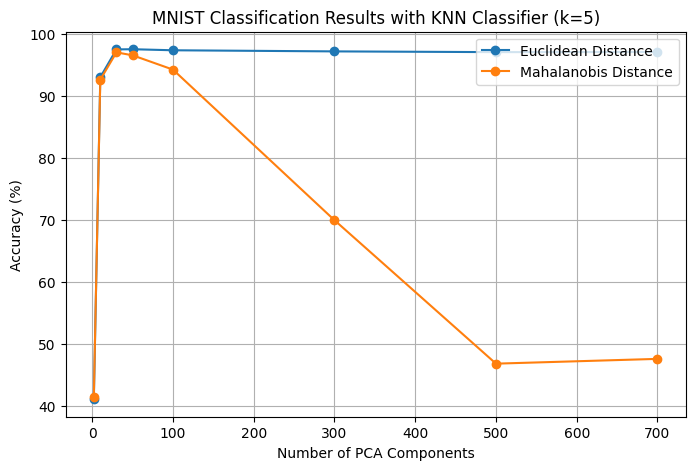

In [39]:
read_lists = []
lines_to_read = [1,4,7]

with open(f'MNIST_knn_{knn_neighbors}.txt', 'r') as f:
    lines = f.readlines()

for idx in lines_to_read:
    line = lines[idx].strip()
    values = [float(x) for x in line.split()]
    read_lists.append(values)


# print(read_lists)
# Output: [[...], [...], [...]]

pca_component = read_lists[0]
acc_euclid = [round(acc * 100, 2) for acc in read_lists[1]]
acc_mahala = [round(acc * 100, 2) for acc in read_lists[2]]


plt.figure(figsize=(8, 5))
# plt.plot(pca_components_list, acc_default_list, pca_components_list, acc_mahala_list, marker='o')
plt.plot(pca_component, acc_euclid, read_lists[0], acc_mahala, marker='o')
# plt.ylim(0, 1)  # y-axis starts from 0 to 1

plt.title(f'MNIST Classification Results with KNN Classifier (k={knn_neighbors})')
plt.xlabel('Number of PCA Components')
plt.ylabel('Accuracy (%)')
plt.legend(['Euclidean Distance','Mahalanobis Distance'], loc='upper right')

plt.grid(True)
plt.savefig("MNIST_acc.png", dpi=300)  # Save with high resolution

plt.show()




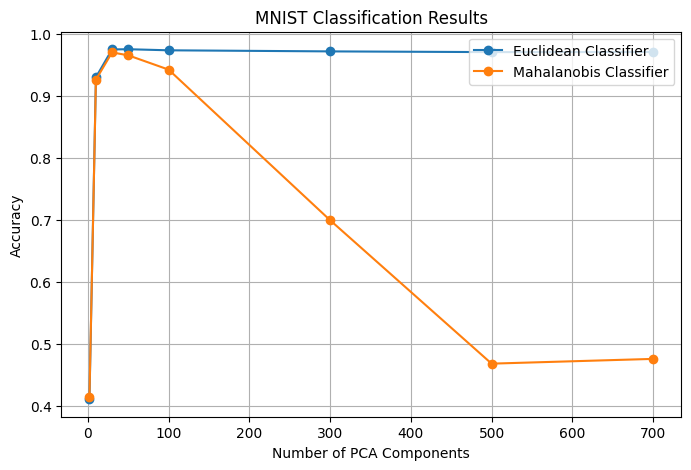

In [21]:
plt.figure(figsize=(8, 5))
# plt.plot(pca_components_list, acc_default_list, pca_components_list, acc_mahala_list, marker='o')
plt.plot(pca_components_list, acc_euclid_list, pca_components_list, acc_mahala_list, marker='o')
# plt.ylim(0, 1)  # y-axis starts from 0 to 1

plt.title(f'MNIST Classification Results with KNN Classifier (k={knn_neighbors})')
plt.xlabel('Number of PCA Components')
plt.ylabel('Accuracy')
plt.legend(['Euclidean Distance','Mahalanobis Distance'], loc='upper right')

plt.grid(True)
plt.show()

